# Astronomical Coordinates 4: Cross-matching Catalogs Using astropy.coordinates and astroquery

## Authors
Adrian Price-Whelan

## Learning Goals
* Demonstrate how to retrieve a catalog from Vizier using astroquery
* Show how to perform positional cross-matches between catalogs of sky coordinates

## Keywords
coordinates, OOP, astroquery, gaia


## Summary

In the previous tutorials in this series, we introduced many of the key concepts underlying how to represent and transform astronomical coordinates using `astropy.coordinates`, including how to work with both position and velocity data within the coordinate objects.

In this tutorial, we will explore how the `astropy.coordinates` package can be used to cross-match two catalogs that contain overlapping sources that may have been observed at different times. You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link. 

*Note: This is the 4th tutorial in a series of tutorials about astropy.coordinates. If you are new to astropy.coordinates, you may want to start from the beginning or an earlier tutorial.*
- [Previous tutorial: Astronomical Coordinates 3: Working with Velocity Data](3-Coordinates-Velocities)

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
matplotlib
numpy



## Imports

We start by importing some general packages that we will need below:

In [2]:
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file

from astroquery.vizier import Vizier

## Cross-matching and comparing catalogs

In this tutorial, we are going to return to a set of data that we downloaded from the *Gaia* archive back in [Tutorial 1](1-Coordinates-Intro) of this series.

Let's recap what we did in that tutorial: We defined a `SkyCoord` object to represent the center of an open cluster (NGC 188), we queried the *Gaia* DR2 catalog to select stars that are close (on the sky) to the center of the cluster, and we used the parallax values from *Gaia* to select stars that are near NGC 188 in 3D position. Here, we will briefly reproduce those selections so that we can start here with a catalog of sources that are likely members of NGC 188 (see [Tutorial 1](1-Coordinates-Intro) for more information):

In [3]:
ngc188_table = QTable.read('gaia_results.fits')
ngc188_table = ngc188_table[ngc188_table['parallax'] > 0.25*u.mas]

ngc188_center_3d = SkyCoord(12.11*u.deg, 85.26*u.deg,
                            distance=1.96*u.kpc,
                            pm_ra_cosdec=-2.3087*u.mas/u.yr,
                            pm_dec=-0.9565*u.mas/u.yr)

# Deal with masked quantity data in a backwards-compatible way:
parallax = ngc188_table['parallax']
if hasattr(parallax, 'mask'):
    parallax = parallax.filled(np.nan)
    
velocity_data = {
    'pm_ra_cosdec': ngc188_table['pmra'],
    'pm_dec': ngc188_table['pmdec'],
    'radial_velocity': ngc188_table['radial_velocity']
}
for k, v in velocity_data.items():
    if hasattr(v, 'mask'):
        velocity_data[k] = v.filled(0.)
    velocity_data[k][np.isnan(velocity_data[k])] = 0.

ngc188_coords_3d = SkyCoord(
    ra=ngc188_table['ra'], 
    dec=ngc188_table['dec'],
    distance=Distance(parallax=parallax),
    obstime=Time('J2015.5'),
    **velocity_data
)

sep3d = ngc188_coords_3d.separation_3d(ngc188_center_3d)
pm_diff = np.sqrt(
    (ngc188_table['pmra'] - ngc188_center_3d.pm_ra_cosdec)**2 + 
    (ngc188_table['pmdec'] - ngc188_center_3d.pm_dec)**2)

ngc188_members_mask = (sep3d < 50*u.pc) & (pm_diff < 1.5*u.mas/u.yr)
ngc188_members = ngc188_table[ngc188_members_mask]
ngc188_members_coords = ngc188_coords_3d[ngc188_members_mask]
len(ngc188_members)

265

From the selections above, the table `ngc188_members` and the `SkyCoord` instance `ngc188_members_coords` contain 216 sources that, based on their 3D positions and proper motions, are consistent with being members of the open cluster NGC 188.

Let's assume that we now want to cross-match our catalog of candidate members of NGC 188 — here, based on *Gaia* data — to some other catalog. In this tutorial, we will demonstrate how to manually cross-match these *Gaia* sources with the 2MASS photometric catalog to retrieve infrared magnitudes for these stars, and then we will plot a color–magnitude diagram. To do this, we first need to query the 2MASS catalog to retrieve all sources in a region around the center of NGC 188, as we did for *Gaia*. Here, we will also take into account the fact that the *Gaia* data release 2 reference epoch is J2015.5, whereas the 2MASS coordinates are likely reported at their time of observation (in the late 1990's). 

*Note that some data archives, like the Gaia science archive, support running cross-matches at the database level and even support epoch propagation. If you need to perform a large cross-match, it will be much more efficient to use these services!*

We will again use `astroquery` to execute this query. This will again require an internet connection, but we have included the results of this query in a file along with this notebook in case you are not connected to the internet. To query 2MASS, we will use the `astroquery.vizier` module ([docs](https://astroquery.readthedocs.io/en/latest/vizier/vizier.html)) to run a cone search centered on the sky position of NGC 188 with a search radius of 0.5º:

In [4]:
# NOTE: skip this cell if you do not have an internet connection

# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/246", columns=['*', 'Date'])  
v.ROW_LIMIT = -1

result = v.query_region(ngc188_center_3d, radius=0.5*u.deg)
tmass_table = result[0]

Alternatively, we can read the 2MASS table provided along with this tutorial:

In [5]:
# the .read() below produces some warnings that we can safely ignore
with warnings.catch_warnings(): 
    warnings.simplefilter('ignore', UserWarning)
    
    tmass_table = QTable.read('2MASS_results.ecsv')

As with the *Gaia* results table, we can now create a single `SkyCoord` object to represent all of the sources returned from our query to the 2MASS catalog. Let's look at the column names in this table by displaying the first few rows:

In [6]:
tmass_table[:3]

Date,RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
,deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
str10,float64,float64,str16,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8
1999-10-19,9.633532,84.808350,00383204+8448300,13.079,0.030,12.742,0.033,12.729,0.035,AAA,222,111,000,0,0
1999-10-19,8.562472,84.873627,00341499+8452250,14.459,0.029,14.103,0.041,14.166,0.063,AAA,222,111,000,0,0
1999-10-19,8.645318,84.868584,00343487+8452069,10.356,0.026,10.057,0.032,10.000,0.020,AAA,222,111,000,0,0


From looking at the column names, the two relevant sky coordinate columns are `RAJ2000` for `ra` and `DEJ2000` for `dec`:

In [7]:
tmass_coords = SkyCoord(tmass_table['RAJ2000'], 
                        tmass_table['DEJ2000'])
len(tmass_coords)

5014

Note also that the table contains a "Date" column that specifies the epoch of the coordinates. Are all of these epochs the same?

In [8]:
np.unique(tmass_table['Date'])

1999-10-19


It looks like all of the sources in our 2MASS table have the same epoch, so let's create an `astropy.time.Time` object to represent this date:

In [9]:
tmass_epoch = Time(np.unique(tmass_table['Date']))

We now want to cross-match our *Gaia*-selected candidate members of NGC 188, `ngc_members_coords`, with this table of photometry from 2MASS. However, as noted previously, the *Gaia* coordinates are given at a different epoch J2015.5, which is nearly ~16 years after the 2MASS epoch of the data we downloaded (1999-10-19 or roughly J1999.88). We will therefore first use the `SkyCoord.apply_space_motion()` method ([docs](http://docs.astropy.org/en/latest/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.apply_space_motion)) to transform the *Gaia* positions back to the 2MASS epoch before we do the cross-match:

In [10]:
# you can ignore the warning raised here
ngc188_members_coords_1999 = ngc188_members_coords.apply_space_motion(
    tmass_epoch)

The object `ngc188_members_coords_1999` now contains the coordinate information for our *Gaia*-selected members of NGC 188, as we think they would appear if observed on 1999-10-19.

We can now use the ``SkyCoord.match_to_catalog_sky`` method to match these two catalogs ([docs](http://docs.astropy.org/en/latest/coordinates/matchsep.html#astropy-coordinates-matching)), using the `ngc188_members_coords_1999` as our NGC 188 members coordinates. 

Note that order matters with this method: Here we will match *Gaia* to 2MASS. `SkyCoord.match_to_catalog_sky` returns three objects: (1) the indices into `tmass_coords` that get the closest matches in `ngc188_members_coords_1999`, (2) the angular separation between each `ngc188_members_coords_1999` coordinate and the closest source in `tmass_coords`, and (3) the 3D distance between each `ngc188_members_coords_1999` coordinate and the closest source in `tmass_coords`. Here, the 3D distances will not be useful because the 2MASS coordinates do not have associated distance information, so we will ignore these quantities:

In [11]:
idx_gaia, sep2d_gaia, _ = ngc188_members_coords_1999.match_to_catalog_sky(
    tmass_coords)

Let's now look at the distribution of separations (in arcseconds) for all of the cross-matched sources:

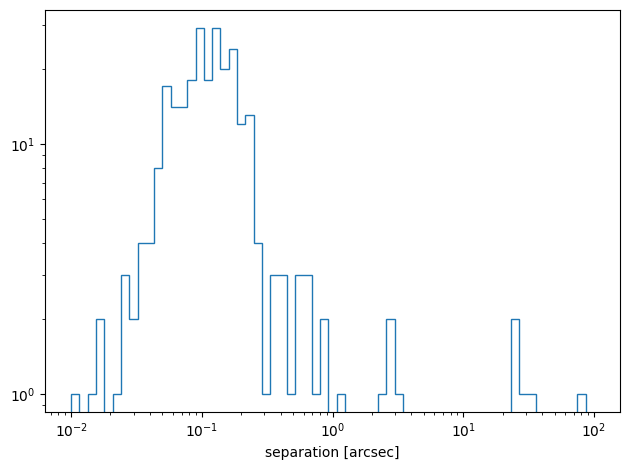

In [12]:
plt.hist(sep2d_gaia.arcsec, histtype='step', 
         bins=np.logspace(-2, 2., 64))
plt.xlabel('separation [arcsec]')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

From this, it looks like all of sources in our *Gaia* NGC 188 member list cross-match to another sources within a few arcseconds, so these all seem like they are correctly matches to a 2MASS source!

In [13]:
(sep2d_gaia < 2*u.arcsec).sum(), len(ngc188_members)

(np.int64(256), 265)

With our cross-match done, we can now make `Gaia`+2MASS color–magnitude diagrams of our candidate NGC 188 members using the information returned by the cross-match:

In [14]:
Jmag = tmass_table['Jmag'][idx_gaia]  # note that we use the index array returned above
Gmag = ngc188_members['phot_g_mean_mag']
Bmag = ngc188_members['phot_bp_mean_mag']

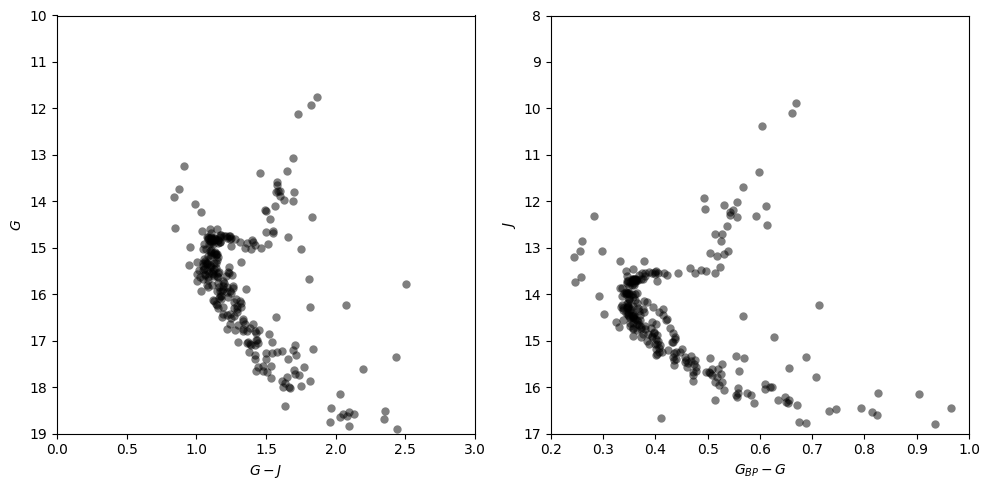

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(Gmag - Jmag, Gmag, 
           marker='o', color='k', 
           linewidth=0, alpha=0.5)
ax.set_xlabel('$G - J$')
ax.set_ylabel('$G$')
ax.set_xlim(0, 3)
ax.set_ylim(19, 10) # backwards because magnitudes!

ax = axes[1]
ax.scatter(Bmag - Gmag, Jmag, 
           marker='o', color='k', 
           linewidth=0, alpha=0.5)
ax.set_xlabel('$G_{BP} - G$')
ax.set_ylabel('$J$')
ax.set_xlim(0.2, 1)
ax.set_ylim(17, 8) # backwards because magnitudes!

fig.tight_layout()

Those both look like color-magnitude diagrams of a main sequence + red giant branch of an intermediate-age stellar cluster, so it looks like our selection and cross-matching has worked!

For more on what matching options are available, check out the [separation and matching section of the Astropy documentation](https://astropy.readthedocs.io/en/stable/coordinates/matchsep.html). Or for more on what you can do with `SkyCoord`, see [its API documentation](http://astropy.readthedocs.org/en/stable/api/astropy.coordinates.SkyCoord.html).